Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's website.

In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, you'll create a few different machine learning models and evaluate their performance.

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In [1]:
import numpy as np
import pandas as pd

bike_rentals =  pd.read_csv("bike_rental_hour.csv")


In [2]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

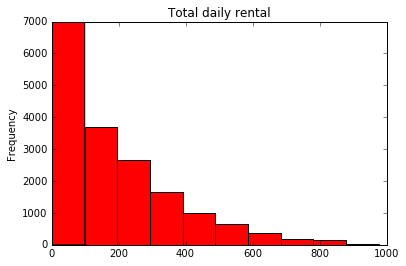

In [4]:
bike_rentals['cnt'].plot(kind='hist',title='Total daily rental',color='r')

In [5]:
corrs = bike_rentals.corr()
target_corrs = corrs['cnt']
target_corrs

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

temperature correlates quite strongly with the total count which makes sense. 

The strongest correlation stems from regular user count. Perhaps this indicates that people who use the bikes often make up a far higher percentage of total count than those who just rent them sporadically. We cant use this informatino anyway since it will in effect be cheating.

the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [6]:
#function to assign part of day the bike was rented with numerical labels
# 1 = 6am-12pm 
# 2 = 12pm-6pm
# 3 = 6pm-12am
# 4 = 12am-6am
def assign_label(time):
    if (time <= 6):
        return 4
    elif ((time > 6) & (time <= 12)):
        return 1
    elif ((time > 12) & (time <= 18)):
        return 2
    else:
        return 3

In [7]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [8]:
bike_rentals['time_label'].value_counts(dropna=False)

4    5001
2    4375
1    4363
3    3640
Name: time_label, dtype: int64

we'll need to ignore the casual and registered columns because cnt is derived from them. If we're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that we'd already know casual or registered, because those numbers are added together to get cnt.

In [9]:
#split the dataframe intoo train and test
#the training columns. Date is meaningless for linear regression
#cnt,casual, registered need to be removed since they reveal information about the target variable
predictors = list(bike_rentals.columns)
predictors.remove('cnt')
predictors.remove('casual')
predictors.remove('registered')
predictors.remove('dteday')
predictors.remove('instant')
predictors.remove('hr')

#make categeorical weather type data usable
#cat 1 = good
#cat 2 = ok
#cat 3 = bad
#cat 4 = very bad

bike_rentals_lr = bike_rentals.copy()
bike_rentals_lr = pd.get_dummies(bike_rentals_lr,prefix='weather_type', columns=['weathersit'])


train = bike_rentals_lr.sample(frac=0.8,axis=0)
test = bike_rentals_lr.loc[~bike_rentals_lr.index.isin(train.index)]


predictors.remove('weathersit')
for i in range(1,5):
    string = 'weather_type_{}'.format(i)
    predictors.append(string)

In [10]:
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,...,hum,windspeed,casual,registered,cnt,time_label,weather_type_1,weather_type_2,weather_type_3,weather_type_4
2092,2093,2011-04-02,2,0,4,1,0,6,0,0.26,...,0.65,0.1343,4,28,32,4,1,0,0,0
7326,7327,2011-11-06,4,0,11,21,0,0,0,0.36,...,0.81,0.0896,11,77,88,3,1,0,0,0
291,292,2011-01-13,1,0,1,14,0,4,1,0.22,...,0.41,0.3881,3,39,42,2,1,0,0,0
14559,14560,2012-09-03,3,1,9,20,1,1,0,0.72,...,0.76,0.1045,78,183,261,3,1,0,0,0
12328,12329,2012-06-02,2,1,6,21,0,6,0,0.60,...,0.40,0.1045,96,220,316,3,1,0,0,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 2092 to 11468
Data columns (total 21 columns):
instant           13903 non-null int64
dteday            13903 non-null object
season            13903 non-null int64
yr                13903 non-null int64
mnth              13903 non-null int64
hr                13903 non-null int64
holiday           13903 non-null int64
weekday           13903 non-null int64
workingday        13903 non-null int64
temp              13903 non-null float64
atemp             13903 non-null float64
hum               13903 non-null float64
windspeed         13903 non-null float64
casual            13903 non-null int64
registered        13903 non-null int64
cnt               13903 non-null int64
time_label        13903 non-null int64
weather_type_1    13903 non-null uint8
weather_type_2    13903 non-null uint8
weather_type_3    13903 non-null uint8
weather_type_4    13903 non-null uint8
dtypes: float64(4), int64(12), object(1), uint8(4)
memory us

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [13]:
lr = LinearRegression()
lr.fit(train[predictors],train['cnt'])
predictions = lr.predict(test[predictors])
mse = mean_squared_error(predictions, test['cnt'])
rmse = mse**0.5

In [14]:
rmse

131.03481658176733

In [15]:
data_below_300_counts = len(bike_rentals[bike_rentals['cnt'] <= 300])
data_above_300_counts = len(bike_rentals) - data_below_300_counts
print(data_below_300_counts)
print(data_above_300_counts)

13488
3891


The majority of our data has 'cnt' values within the range of 0-300. An error of 131 is not good at all considering this. That said, there is almost 4000 instaces with 'cnt' values  between 300 and 1000. The large error could be explained because of the use of error metric. Like variance, mean squared error has the disadvantage of heavily weighting outliers. This is a result of the squaring of each term, which effectively weights large errors more heavily than small ones.

# Decision Tree

Now we're ready to apply the decision tree algorithm. we'll be able to compare its error with the error from linear regression, which will enable us to pick the right algorithm for this data set.

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
#we dont need to one-hot encode the categorical data to use it with DTree
bike_rentals_dt = bike_rentals.copy()
predictors = list(bike_rentals.columns)
predictors.remove('cnt')
predictors.remove('casual')
predictors.remove('registered')
predictors.remove('dteday')
predictors.remove('instant')



train = bike_rentals_dt.sample(frac=0.8,axis=0)
test = bike_rentals_dt.loc[~bike_rentals_dt.index.isin(train.index)]


dt = DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(train[predictors], train['cnt'])
predictions = dt.predict(test[predictors])
mse = mean_squared_error(predictions, test['cnt'])
rmse = mse**0.5
print(rmse)
print('')

90.9123412825143



In [18]:
#from IPython.display import Image
#from sklearn import tree

#text_representation = tree.export_text(dt)
#print(text_representation)

Decision tree works much better with the default hyperparameters than linear regression. Lets experiment with a few different values for hyperparameters to see if we can improve on this

In [19]:
import numpy as np 
max_depths = [None] + list(np.arange(1,50))
min_samples_splits = list(np.arange(2,10))


In [20]:
best_depth = None
best_min_sample_split = 2
best_error = rmse
for depth in max_depths:
    for min_sample_split_size in min_samples_splits:
        dt = DecisionTreeClassifier(min_samples_leaf=min_sample_split_size, max_depth=depth)
        dt.fit(train[predictors], train['cnt'])
        predictions = dt.predict(test[predictors])
        mse = mean_squared_error(predictions, test['cnt'])
        rmse = mse**0.5
        if rmse < best_error:
            best_depth = depth
            best_min_sample_split = min_sample_split_size
            best_error = rmse
print('best combination is:\n depth = {}\n min_sample_split = {}\n which acheieves an rmse of {}'.format(best_depth,best_min_sample_split,best_error))
        

best combination is:
 depth = 36
 min_sample_split = 2
 which acheieves an rmse of 83.1287129179347


# Hyperparameters 
By tuning the hyperparameters regarding depth and the minimum amount of data we need to warrant a split, we've reduced the error by around 6. 

# Random Forests

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
dt.decision_path(test[predictors].iloc[0:2]).todense()

matrix([[1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]])

In [23]:
best_min_sample_split = 2
best_error = rmse
#how many trees do we want in our forests
forest_sizes = [2,5,20,30,50,100]

rmses = pd.DataFrame(columns=['trees_in_forest','best_rmse','minimum_split_size'])

for forest_size in forest_sizes:
    #first combination, assiign to best initilally 
    rf = RandomForestRegressor(n_estimators = forest_size, min_samples_leaf=min_samples_splits[0])
    rf.fit(train[predictors], train['cnt'])
    predictions = rf.predict(test[predictors])
    mse = mean_squared_error(predictions, test['cnt'])
    rmse = mse**0.5
    forest_best_rmse = rmse
    forest_best_min_split = min_samples_splits[0]
    #now compare to other combinations
    for i in range(1,len(min_samples_splits)):
        rf = RandomForestRegressor(n_estimators = forest_size,min_samples_leaf= min_samples_splits[i])
        rf.fit(train[predictors], train['cnt'])
        predictions = rf.predict(test[predictors])
        mse = mean_squared_error(predictions, test['cnt'])
        rmse = mse**0.5
        
        #the best rmse over all trees/split_size combos
        if(rmse < forest_best_rmse):
            forest_best_rmse = rmse
            forest_best_min_split = min_samples_splits[i]
    
    row = [int(forest_size),forest_best_rmse,int(forest_best_min_split)]         
    rmses.loc[len(rmses)] = row  
        

 Using a combination of trees in a random forest, we significantly reduced our error.

In [24]:
rmses

,trees_in_forest,best_rmse,minimum_split_size
0,2.0,50.931613,2.0
1,5.0,45.715654,2.0
2,20.0,43.080446,2.0
3,30.0,42.487576,2.0
4,50.0,42.075501,2.0
5,100.0,42.022943,2.0


In [25]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

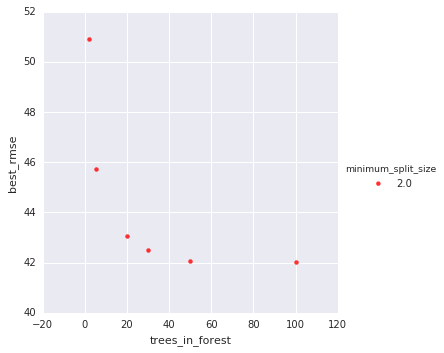

In [26]:

sns.lmplot(x="trees_in_forest", y="best_rmse", hue="minimum_split_size",data=rmses,
          fit_reg=False,palette=['red','green'])